In [2]:
import numpy as np

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from skimage import measure

import seaborn as sns

In [3]:
#sns.set(style="white")
#sns.set_context("paper")

def figsize(scale,ratio):
    fig_width_pt = 468.0                      # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    if(ratio == "golden"):                          # Golden ratio ...
        fig_height = fig_width*golden_mean          # height in inches
    else:                                           # ... or other ratio
        fig_height = fig_width*ratio
        
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {'backend': 'pdf',
                                            'axes.labelsize': 8,
                                            'xtick.labelsize': 8,
                                            'ytick.labelsize': 8,
                                            'legend.fontsize': 8,
                                            'lines.markersize': 3,
                                            'font.size': 8,
                                            'font.family': u'sans-serif',
                                            'font.sans-serif': ['Arial'],
                                            'pdf.fonttype': 42,
                                              'ps.fonttype': 42,
                                            'text.usetex': False}
matplotlib.rcParams.update(pgf_with_latex)

In [4]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def crop_center(img, width, height):
    fill_percentage = 0
    cropped_img = None
    while fill_percentage < 0.2 or fill_percentage > 0.65:
        x = np.random.randint(0, img.shape[1] - width)
        y = np.random.randint(0, img.shape[0] - height)
        cropped_img = img[y:y+height, x:x+width]
        
        fill_percentage = np.array(cropped_img).sum()/(cropped_img.shape[0]**2)
    
    return cropped_img

def random_inset(M, axs, cmap_black, size=40):
    inset_axes2 = inset_axes(axs,
                        width="28%", # width = 30% of parent_bbox
                        height="28%", # height : 1 inch
                        loc="lower right")
    inset_axes2.imshow(crop_center(M, size, size), aspect='equal', cmap=cmap_black)
    inset_axes2.set_yticklabels([])
    inset_axes2.set_xticklabels([])
    inset_axes2.xaxis.set_ticks_position('none')
    inset_axes2.yaxis.set_ticks_position('none')
    return inset_axes2

In [5]:
def retrieve_simulation(name, step, temporal=False):
    d = '1000'
    if 'marco' in name:
        d = 'marco'
    M_sim1 = np.load(open('../data/generated_files/simulations2steps/{}/{}.npz'.format(d, name), 'rb'))['M']
    if temporal:
        M_sim1[(M_sim1 <= step)] = 0
    else:
        M_sim1 = 1*(M_sim1 > step)
    #M_sim1 = np.ma.array(M_sim1, mask=M_sim1 == 0)
    return M_sim1

def retrieve_tile(tileid):
    fload = np.load('../data/cache_numpy_05x05/{}.npz'.format(tileid))
    M = fload['M']
    #M = np.ma.array(M, mask=M == 0)
    return M

In [6]:
def sample_from_ccdf(x, y, samples=1):
    """
    x,y  :  arrays, x and y outputs of a ccdf (sorted)
    samples  :  int, number of samples to draw
    """
    n = len(x) - 1
    uniform_samples = np.random.random(samples)
    indexes = np.searchsorted(1. - np.array(y) , uniform_samples)
    return np.array([x[min(i,n)] for i in indexes])


def get_urban_phase_class(macro, urban_area_km2, num_urban, tile_km2, macro2ccdf_rescaled4, num_realisations=5000, num_samples=500):
    
    x,y,n = macro2ccdf_rescaled4[macro]
        
    if urban_area_km2 > 0. and urban_area_km2 < tile_km2:  # and tile_km2 > alim

        null_model_num_urb = []
        for r in range(num_realisations):
            samples = []
            sum_samples = 0.
            model_num_urb = 0.
            while sum_samples < urban_area_km2: 
                model_num_urb += num_samples
                new_draw = sample_from_ccdf(x, y, samples=num_samples)
                sum_samples += sum(new_draw)
#                 samples += list(new_draw)
#             cumsum_samples = np.cumsum(samples)
#             model_num_urb = np.searchsorted(cumsum_samples, urban_area_km2 )

            model_num_urb -= num_samples
            sum_samples -= sum(new_draw)
            model_num_urb += np.searchsorted(np.cumsum(new_draw), urban_area_km2 - sum_samples )

            null_model_num_urb += [model_num_urb]

        return 1.* np.searchsorted(sorted(null_model_num_urb), num_urban) / len(null_model_num_urb)
    
def get_clusters_area(M):
	labels = measure.label(M, connectivity=2)
	regions = measure.regionprops(labels)
	cluster_pop = np.zeros(len(regions), dtype='float32')
	for i, x in enumerate(regions):
		cluster_pop[i] = x.area

	return cluster_pop

def find_phase_class_from_tile(M_sim, tileid_ref):
    fname = '../data/generated_files/macro2ccdf_rescaled4.json'
    with open(fname, 'r') as f:
        macro2ccdf_rescaled4 = json.load(f)

    # Example    
    macro, orig_tile_km = df_summary_macro.loc[tileid_ref, 'macro'], df_summary_macro.loc[tileid_ref, 'original_km2']
    urban_area_km2, num_urban, tile_km2 = (M_sim.sum()/(1000**2))*orig_tile_km, len(get_clusters_area(M_sim)), orig_tile_km
    q = get_urban_phase_class(macro, urban_area_km2, num_urban, tile_km2, macro2ccdf_rescaled4, num_realisations=1000)
    
    return q

def phase2class(phase):
    cl = 4
    
    if 0.1 < phase <= 0.5:
        cl = 2
    elif 0.5 < phase < 0.9:
        cl = 3
    elif phase <= 0.1:
        cl = 1
        
    return cl

In [7]:
df_summary = pd.read_csv('../data/generated_files/summary_tiles_05x05.csv', dtype={'tileid': 'str'})#
#df_classes = pd.merge(df_classes, df_summary, on='tileid')
df_summary = df_summary.set_index('tileid')
df_summary.head()

,urban_area_km2,urban_areas_num,tile_km2,original_km2
tileid,,,,
46585,0.000000,0,0.572563,1748.407403
46586,0.000000,0,22.378058,1748.407403
46587,0.000000,0,22.334546,1748.407403
46588,0.007575,1,183.837976,1748.407403
46589,0.000000,0,216.701088,1748.407403


In [8]:
df_macro = pd.read_csv('../data/generated_files/macro_05x05.csv', dtype={'tileid': 'str'})
df_macro = df_macro.sort_values('tile_km2', ascending=False).groupby('tileid').first()
df_macro = df_macro[['macro']]
df_macro.head()

,macro
tileid,
100068,Australia N. Zealand
100069,Australia N. Zealand
100070,Australia N. Zealand
100071,Australia N. Zealand
100072,Australia N. Zealand


In [9]:
df_summary_macro = pd.merge(df_summary, df_macro, left_index=True, right_index=True)
df_summary_macro.head()

,urban_area_km2,urban_areas_num,tile_km2,original_km2,macro
tileid,,,,,
46585,0.000000,0,0.572563,1748.407403,South America
46586,0.000000,0,22.378058,1748.407403,South America
46587,0.000000,0,22.334546,1748.407403,South America
46588,0.007575,1,183.837976,1748.407403,South America
46589,0.000000,0,216.701088,1748.407403,South America


### Manuscript

In [10]:
def get_best_conf(tileid, model_type):
    js = json.load(open('../data/generated_files/simulations/energy{}_1000x1000_lb0.01_hb1.0_all.json'.format(model_type)))[tileid]
    
    g1, g2, s = js[2][0]
    step = js[4][0]
    
    return g1, g2, s, step

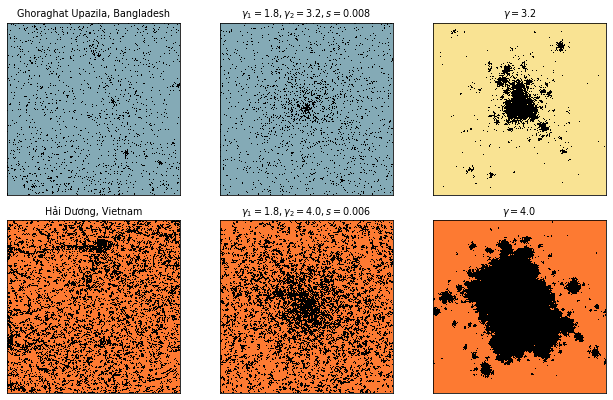

In [12]:
import string 
import json
from matplotlib import colors

cmaps = [
    colors.ListedColormap([np.array([253, 122, 50])/255., np.array([0, 0, 0])/255.]), # dense
    colors.ListedColormap([np.array([249, 227, 147])/255., np.array([0, 0, 0])/255.]),
    colors.ListedColormap([np.array([226, 241, 199])/255., np.array([0, 0, 0])/255.]),
    colors.ListedColormap([np.array([132, 170, 182])/255., np.array([0, 0, 0])/255.]),#sparse
]
phase_2_color = lambda phase: cmaps[int(phase2class(phase)-1)]
class_2_color = lambda cls: cmaps[int(cls-1)]


f, axs = plt.subplots(2, 3, figsize=figsize(1.4, "golden"))

tileid_ref = '161599'
phase_ref = 4
M = retrieve_tile(tileid_ref)
axs[0,0].imshow(M, aspect='equal', cmap=class_2_color(phase_ref))
axs[0,0].set_title('Ghoraghat Upazila, Bangladesh')

g1, g2, s, step = get_best_conf(tileid_ref, '1000')
M_best = retrieve_simulation('rybski_2steps_1000x1000_s{s}_{g1}_{g2}'.format(s=s, g1=g1, g2=g2), step)
sim_class_our1 = find_phase_class_from_tile(M_best, tileid_ref)
axs[0,1].imshow(M_best, aspect='equal', cmap=phase_2_color(sim_class_our1))
axs[0,1].set_title(r'$\gamma_1 = {g1}, \gamma_2={g2}, s={s}$'.format(s=s, g1=g1, g2=g2))

g, _, s, step = get_best_conf(tileid_ref, 'rybski')
M_worst = retrieve_simulation('rybski_2steps_1000x1000_s{s}_{g1}_{g2}'.format(s=s, g1=g, g2=g), step)
sim_class_ryb1 = find_phase_class_from_tile(M_worst, tileid_ref)
axs[0,2].imshow(M_worst, aspect='equal', cmap=phase_2_color(sim_class_ryb1))
axs[0,2].set_title(r'$\gamma={g}$'.format(g=g))

#random_inset(M, axs[0,0], class_2_color(phase_ref), size=50)
#random_inset(M_best, axs[0,1], phase_2_color(sim_class_our1), size=50)
#random_inset(M_worst, axs[0,2], phase_2_color(sim_class_ryb1), size=50)

tileid_ref = '155261'
phase_ref = 1
M = retrieve_tile(tileid_ref)
axs[1,0].imshow(M, aspect='equal', cmap=class_2_color(phase_ref)) #[196:1196, 196:1196]
axs[1,0].set_title('Hải Dương, Vietnam')

g1, g2, s, step = get_best_conf(tileid_ref, '1000')
M_best = retrieve_simulation('rybski_2steps_1000x1000_s{s}_{g1}_{g2}'.format(s=s, g1=g1, g2=g2), step)
sim_class_our2 = find_phase_class_from_tile(M_best, tileid_ref)
axs[1,1].imshow(M_best, aspect='equal', cmap=phase_2_color(sim_class_our2))
axs[1,1].set_title(r'$\gamma_1 = {g1}, \gamma_2={g2}, s={s}$'.format(s=s, g1=g1, g2=g2))

g, _, s, step = get_best_conf(tileid_ref, 'rybski')
M_worst = retrieve_simulation('rybski_2steps_1000x1000_s{s}_{g1}_{g2}'.format(s=s, g1=g, g2=g), step)
sim_class_ryb2 = find_phase_class_from_tile(M_worst, tileid_ref)
axs[1,2].imshow(M_worst, aspect='equal', cmap=phase_2_color(sim_class_ryb2))
axs[1,2].set_title(r'$\gamma={g}$'.format(g=g))

#random_inset(M, axs[1,0], class_2_color(phase_ref), size=50)
#random_inset(M_best, axs[1,1], phase_2_color(sim_class_our2), size=50)
#random_inset(M_worst, axs[1,2], phase_2_color(sim_class_ryb2), size=50)

for n, ax in enumerate(axs.flatten()):
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

plt.tight_layout()
plt.savefig('../figures/manuscript/simulations.png', dpi=300, bbox_inches='tight', pad_inches=0.05, interpolation='none') #

## Supplementary figures

In [31]:
df_classes = pd.read_csv('../data/generated_files/quantiles_classes.csv', dtype={'tileid': str})
df_classes.head()

,tileid,class,quantile
0,46588,2,0.307
1,47297,3,0.544
2,48000,2,0.428
3,48003,3,0.811
4,48004,2,0.353


In [84]:
df_summary = pd.read_csv('../data/generated_files/summary_tiles_05x05.csv', dtype={'tileid': str})
df_summary['percent_urban'] = (df_summary['urban_area_km2']/df_summary['tile_km2'])*100
df_summary.loc[df_summary['percent_urban']<0, 'percent_urban'] = 0
df_summary.loc[df_summary['percent_urban']>100, 'percent_urban'] = 100
df_summary = df_summary.sort_values(['percent_urban', 'tile_km2'])
df_summary.head()

,tileid,urban_area_km2,urban_areas_num,tile_km2,original_km2,percent_urban
19190,147342,0.0,0,0.000001,2972.529465,0.0
36802,187888,0.0,0,0.000235,2237.358095,0.0
770,69018,0.0,0,0.000457,2362.722662,0.0
21860,155223,0.0,0,0.000700,2883.264965,0.0
771,69022,0.0,0,0.001430,2362.722662,0.0


In [33]:
import json

simulations_js = json.load(open('../data/generated_files/simulations/energy1000_1000x1000_lb0.01_hb1.0_all.json'))
simulations_js_rybski = json.load(open('../data/generated_files/simulations/energyrybski_1000x1000_lb0.01_hb1.0_all.json'))
simulated_tileids = list(simulations_js.keys())

In [73]:
df_classes_dist = df_classes[df_classes.tileid.isin(simulated_tileids)].set_index('tileid')
df_classes_dist['dist'] = 0
for t in simulated_tileids:
    df_classes_dist.loc[t, 'dist'] = (simulations_js_rybski[t][0][0] - simulations_js[t][0][0])
    
df_classes_dist = pd.merge(df_classes_dist, df_summary[['tileid', 'percent_urban']], left_index=True, right_on='tileid').set_index('tileid')

#df_classes_dist = df_classes_dist.drop_duplicates(subset=['class', 'percent_urban'])
df_classes_dist.head()

,class,quantile,dist,percent_urban
tileid,,,,
50123,2,0.126,0.099520,11
52250,2,0.166,0.138261,1
60513,2,0.247,0.030609,1
60749,2,0.166,0.236379,1
61225,1,0.079,0.037032,2


In [101]:
df_sampled = df_classes_dist.groupby('class')['dist'].nlargest(100).to_frame().reset_index()
df_sampled = pd.merge(df_sampled, df_summary[['tileid', 'percent_urban']])
df_sampled.loc[:, 'percent_urban'] = df_sampled['percent_urban']//2*2
df_sampled.loc[:, 'percent_urban'] = df_sampled['percent_urban'].astype(int)

df_sampled = df_sampled.drop_duplicates(subset=['class', 'percent_urban']).groupby('class').apply(lambda x: x.sample(n=8, random_state=42)).set_index('tileid')
df_sampled.head()

,class,dist,percent_urban
tileid,,,
115621,1,1.564641,22
189993,1,2.510259,6
166525,1,4.151733,0
173691,1,2.551224,10
173684,1,3.012785,16


In [102]:
len(df_sampled)

32

In [103]:
import string 
from matplotlib import colors

cmap_black = colors.ListedColormap([np.array([255, 255, 255])/255., np.array([0, 0, 0])/255.])


/home/denadai/.local/share/virtualenvs/ema-lfvilRpo/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


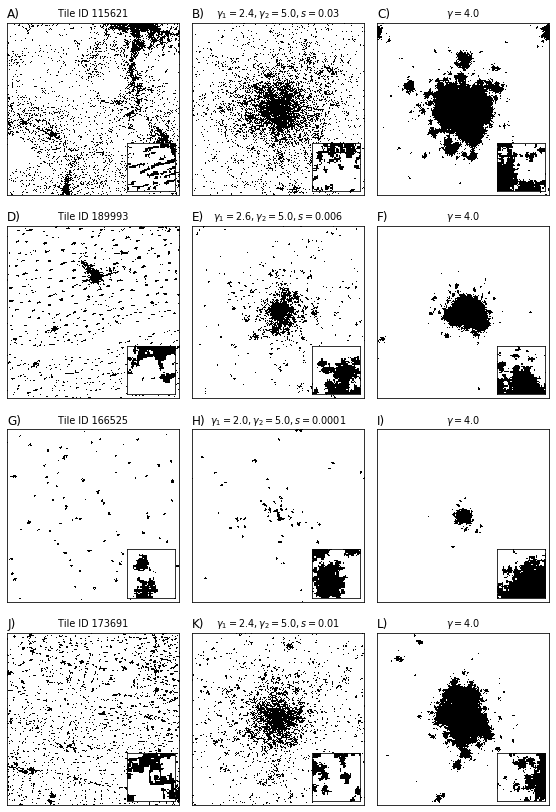

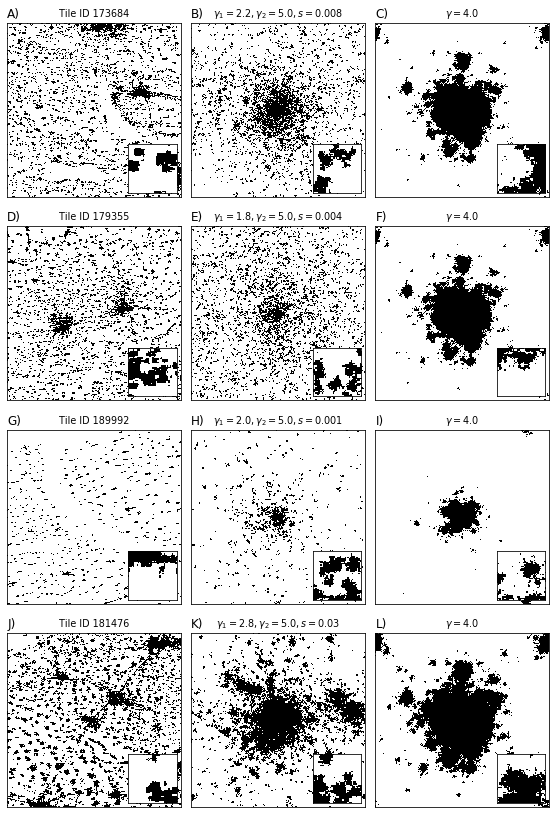

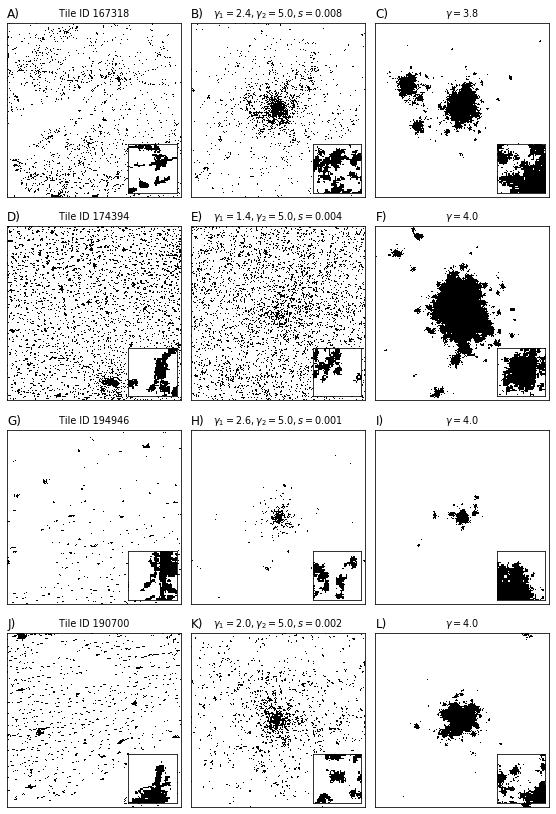

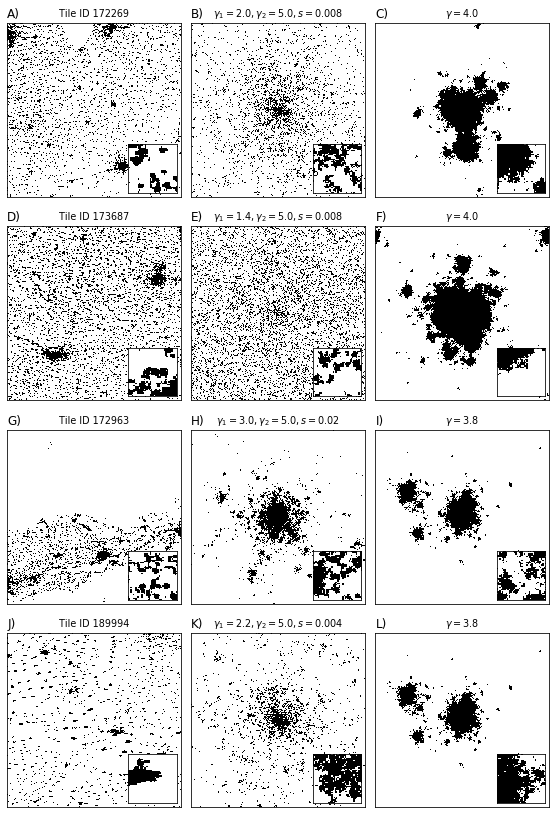

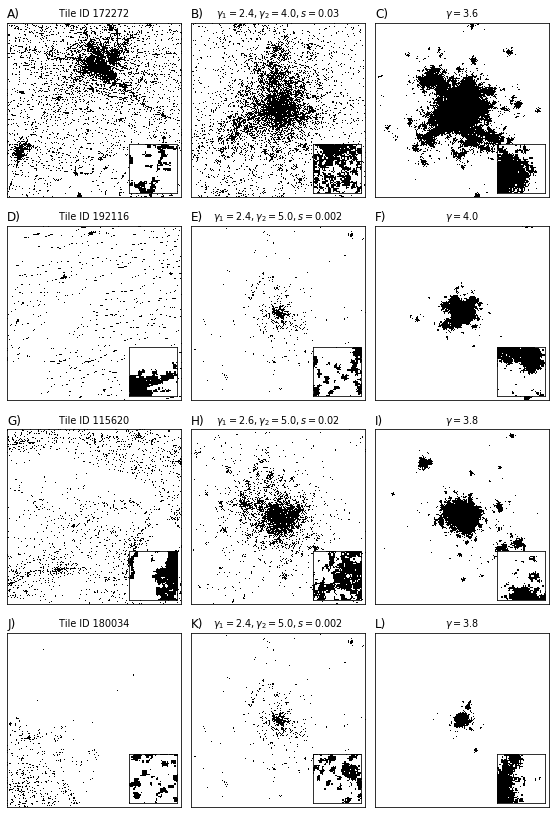

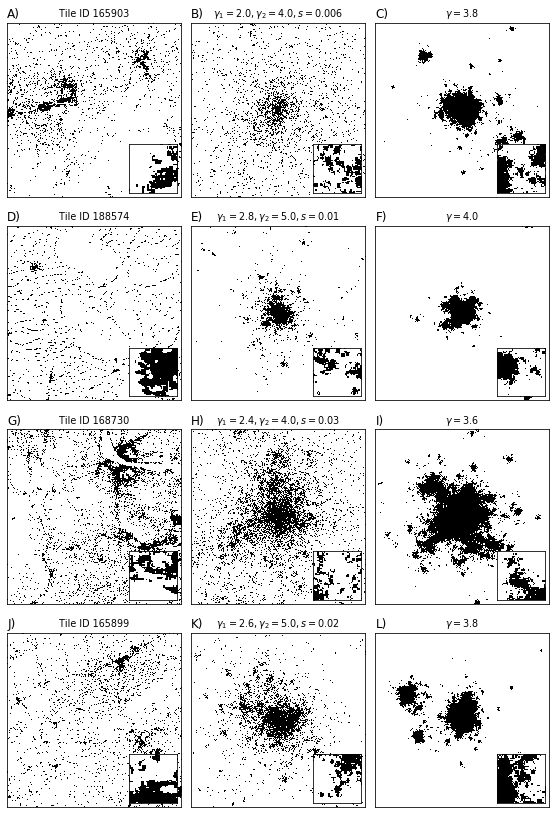

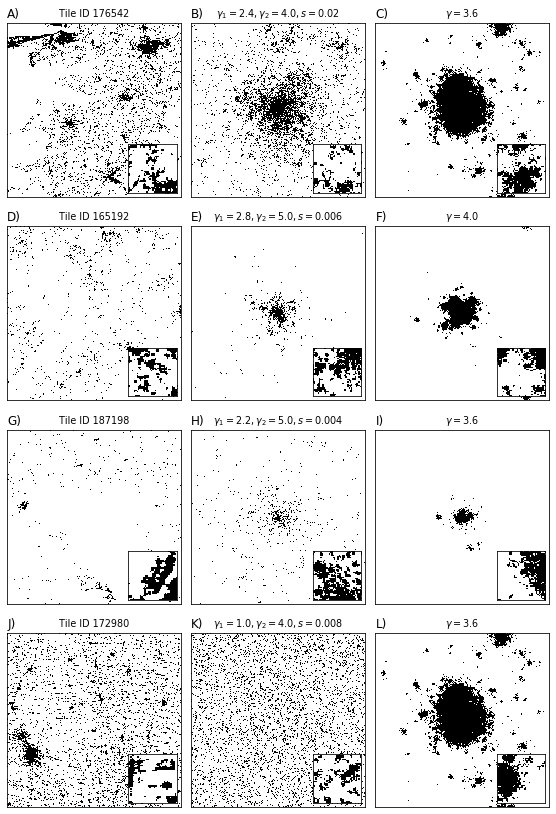

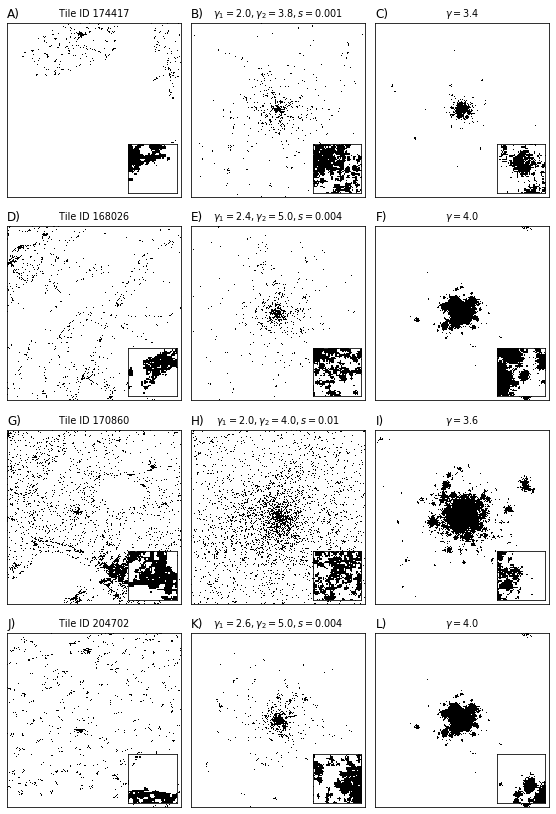

In [104]:
for class_considered in [1,2,3,4]: #
    for iteration in [1,2]:
        f, axs = plt.subplots(4, 3, figsize=figsize(1.2, 1.5))
        counter = 0

        df_class_selected = df_sampled[df_sampled['class'] == class_considered][int(4*iteration-4):int(4*iteration)]

        for tileid, row in df_class_selected.iterrows():
            M = retrieve_tile(tileid)
            axs[counter, 0].imshow(M, aspect='equal', cmap=cmap_black)
            axs[counter, 0].set_title('Tile ID {}'.format(tileid))

            best_params = simulations_js[tileid][2][0]
            best_step = simulations_js[tileid][4][0]

            best_params_ryb = simulations_js_rybski[tileid][2][0]
            best_step_ryb = simulations_js_rybski[tileid][4][0]

            M_best = retrieve_simulation('rybski_2steps_1000x1000_s{s}_{g1}_{g2}'.format(g1=best_params[0], g2=best_params[1], s=best_params[2]), best_step)
            axs[counter, 1].imshow(M_best, aspect='equal', cmap=cmap_black)
            axs[counter, 1].set_title(r'$\gamma_1 = {g1}, \gamma_2={g2}, s={s}$'.format(g1=best_params[0], g2=best_params[1], s=best_params[2]))
            M_worst = retrieve_simulation('rybski_2steps_1000x1000_s{s}_{g1}_{g2}'.format(g1=best_params_ryb[0], g2=best_params_ryb[1], s=best_params_ryb[2]), best_step_ryb)
            axs[counter, 2].imshow(M_worst, aspect='equal', cmap=cmap_black)
            axs[counter, 2].set_title(r'$\gamma = {g1}$'.format(g1=best_params_ryb[0]))

            random_inset(M, axs[counter, 0], cmap_black)
            random_inset(M_best, axs[counter, 1], cmap_black)
            random_inset(M_worst, axs[counter, 2], cmap_black)

            counter += 1

        for n, ax in enumerate(axs.flatten()):
            ax.text(0.0, 1.03, string.ascii_uppercase[n]+')', transform=ax.transAxes, size=12, color='black')
            #ax.axis('off')
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.xaxis.set_ticks_position('none')
            ax.yaxis.set_ticks_position('none')

        plt.tight_layout()
        plt.subplots_adjust(hspace = 0.01)
        plt.savefig('../figures/manuscript/appendix_simulations_cl{}-{}.png'.format(class_considered, iteration), dpi=150, bbox_inches='tight', pad_inches=0.05)

## Examplar image

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


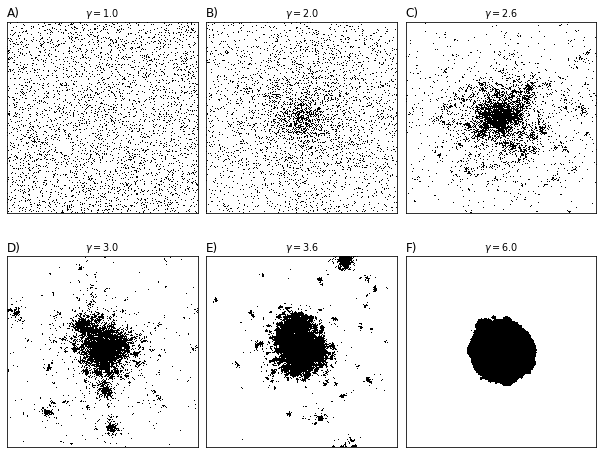

In [66]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx

def retrieve_simulation(name, step, urb):
    d = '1000'
    if 'marco' in name:
        d = 'marco'
    sim1 = np.load(open('../data/generated_files/simulations2steps/{}/{}.npz'.format(d, name), 'rb'))
    cache_sim = np.load(open('../data/generated_files/cachesimulations/{}/{}.npz'.format(d, name), 'rb'))
    
    M_sim1 = sim1['M']
    perc_array = cache_sim['perc']
    step = find_nearest(perc_array, urb)
    M_sim1 = 1*(M_sim1 > step)
    #M_sim1 = np.ma.array(M_sim1, mask=M_sim1 == 0)
    return M_sim1


URB = 0.1
f, axs = plt.subplots(2, 3, figsize=figsize(1.3, 0.8))
axs = np.ravel(axs)

for i, p in enumerate([1.0, 2.0, 2.6, 3.0, 3.6, 6.0]):
    M_best = retrieve_simulation('rybski_2steps_1000x1000_s{s}_{g1}_{g2}'.format(g1=p, g2=p, s=0.5), 10, URB)
    axs[i].imshow(M_best, aspect='equal', cmap=cmap_black)
    axs[i].set_title(r'$\gamma = {g1}$'.format(g1=p))

for n, ax in enumerate(axs.flatten()):
    ax.text(0.0, 1.03, string.ascii_uppercase[n]+')', transform=ax.transAxes, size=12, color='black')
    #ax.axis('off')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    
plt.tight_layout()
plt.subplots_adjust(hspace = 0.01)
plt.savefig('../figures/manuscript/appendix_explain_rybski.png', dpi=150, bbox_inches='tight', pad_inches=0.05)

43 189.0
34 120.0
33 117.0
31 113.0
31 112.0
31 112.0


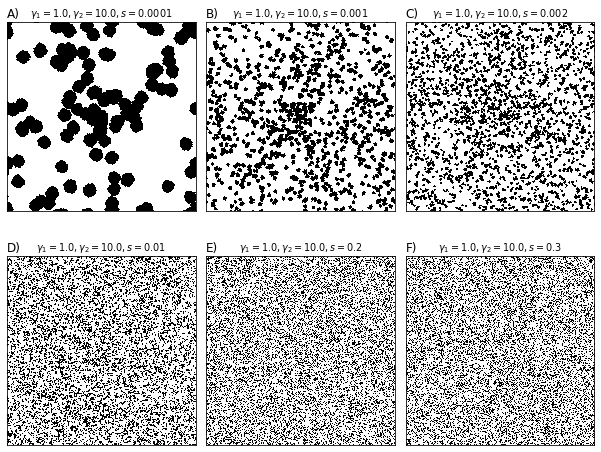

In [67]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx

def retrieve_simulation(name, step, urb):
    d = '1000'
    if 'marco' in name:
        d = 'marco'
    sim1 = np.load(open('../data/generated_files/simulations2steps/{}/{}.npz'.format(d, name), 'rb'))
    cache_sim = np.load(open('../data/generated_files/cachesimulations/{}/{}.npz'.format(d, name), 'rb'))
    
    M_sim1 = sim1['M']
    perc_array = cache_sim['perc']
    step = find_nearest(perc_array, urb)
    print(step, M_sim1.max())
    M_sim1 = 1*(M_sim1 > step)
    #M_sim1 = np.ma.array(M_sim1, mask=M_sim1 == 0)
    return M_sim1


URB = 0.3
f, axs = plt.subplots(2, 3, figsize=figsize(1.3, 0.8))
axs = np.ravel(axs)

g1 = 1.0
g2 = 10.0
for i, s in enumerate([0.0001, 0.001, 0.002, 0.01, 0.2, 0.3]):
    M_best = retrieve_simulation('rybski_2steps_1000x1000_s{s}_{g1}_{g2}'.format(g1=g1, g2=g2, s=s), 10, URB)
    axs[i].imshow(M_best, aspect='equal', cmap=cmap_black)
    axs[i].set_title(r'$\gamma_1 = {g1}, \gamma_2={g2}, s={s}$'.format(g1=g1, g2=g2, s=s))

for n, ax in enumerate(axs.flatten()):
    ax.text(0.0, 1.03, string.ascii_uppercase[n]+')', transform=ax.transAxes, size=12, color='black')
    #ax.axis('off')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    
plt.tight_layout()
plt.subplots_adjust(hspace = 0.01)
plt.savefig('../figures/manuscript/appendix_explain_multi.png', dpi=150, bbox_inches='tight', pad_inches=0.05)